In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting

In [7]:
def nnls_path(X, Y, tol=1e-12, max_iter=500):
    """
    Implements a simple Lawson-Hanson NNLS algorithm while recording the iterates.
    This function solves:
        minimize || Xβ - Y ||^2  subject to  x >= 0
    and returns the final solution and a list of x values (the optimization path).
    """
    m, n = X.shape
    beta = np.zeros(n)
    # P: passive set (free variables), Z: active set (currently set to zero)
    P = []         # indices in the current free set
    Z = list(range(n))
    path = [beta.copy()]  # record the starting point

    # compute initial gradient
    w = X.T @ (Y - X @ beta)
    iter_count = 0

    while np.any(w[Z] > tol) and iter_count < max_iter:
        # Choose index t from Z with maximum gradient
        t = Z[np.argmax(w[Z])]
        if w[t] <= tol:
            break

        # Move t from Z to P
        P.append(t)
        Z.remove(t)

        # Inner loop: find feasible solution for variables in P
        while True:
            # Solve least-squares for the subproblem with indices in P
            Xp = X[:, P]
            z, residuals, rank, s = np.linalg.lstsq(Xp, Y, rcond=None)
            z_full = np.zeros(n)
            # Place the computed values in their corresponding positions
            for i, idx in enumerate(P):
                z_full[idx] = z[i]

            # Check feasibility (strict positivity) for indices in P
            if np.all(z > tol):
                beta = z_full.copy()
                path.append(beta.copy())
                break
            else:
                # Find the maximum step size alpha such that beta + alpha*(z - beta) remains nonnegative.
                alphas = []
                for i, idx in enumerate(P):
                    if z[i] <= tol:
                        # Avoid division by zero; here x[idx] is nonnegative already.
                        if beta[idx] - z[i] > tol:
                            alphas.append(beta[idx] / (beta[idx] - z[i]))
                if len(alphas) == 0:
                    alpha = 1.0
                else:
                    alpha = min(alphas)
                beta = beta + alpha * (z_full - beta)
                path.append(beta.copy())
                # Remove indices that hit zero
                to_remove = [idx for idx in P if abs(beta[idx]) < tol]
                for idx in to_remove:
                    P.remove(idx)
                    if idx not in Z:
                        Z.append(idx)
            iter_count += 1

        w = X.T @ (Y - X @ beta)
        iter_count += 1

    return beta, path

In [8]:

def plot_path(path, dimension=2):
    """
    Plots the recorded optimization path.
    For 2D, a simple x-y plot is used.
    For 3D, a 3D line plot is created.
    """
    path = np.array(path)
    if dimension == 2:
        plt.figure(figsize=(6, 5))
        plt.plot(path[:, 0], path[:, 1], marker='o', linestyle='-')
        plt.xlabel('x[0]')
        plt.ylabel('x[1]')
        plt.title('NNLS Optimization Path (2D)')
        plt.grid(True)
        plt.show()
    elif dimension == 3:
        fig = plt.figure(figsize=(7, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(path[:, 0], path[:, 1], path[:, 2], marker='o', linestyle='-')
        ax.set_xlabel('x[0]')
        ax.set_ylabel('x[1]')
        ax.set_zlabel('x[2]')
        ax.set_title('NNLS Optimization Path (3D)')
        plt.show()
    else:
        print("Visualization for dimension {} is not supported.".format(dimension))


Running NNLS on a 2D example...


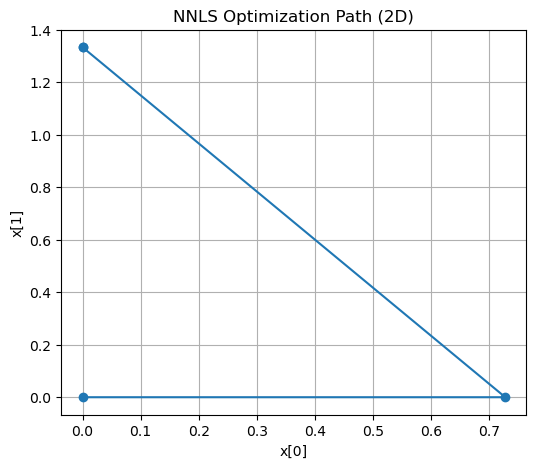

2D NNLS solution: [0.         1.33333333]
Step 0: [0. 0.]
Step 1: [0.7273 0.    ]
Step 2: [0.     1.3333]
Step 3: [0.     1.3333]


In [21]:

# --- 2D Example ---
print("Running NNLS on a 2D example...")
# For a 2D NNLS problem, let A be 3x2 and b be 3x1.
X2D = np.array([[3, 1],
                [1, 2],
                [1, 1]], dtype=float)

Y2D = np.array([1, 2, 3], dtype=float)
sol2D, path2D = nnls_path(X2D, Y2D)
plot_path(path2D, dimension=2)
print("2D NNLS solution:", sol2D)
for i, beta in enumerate(path2D):
    print(f"Step {i}: {np.round(beta, decimals=4)}")

Running NNLS on a 3D example...


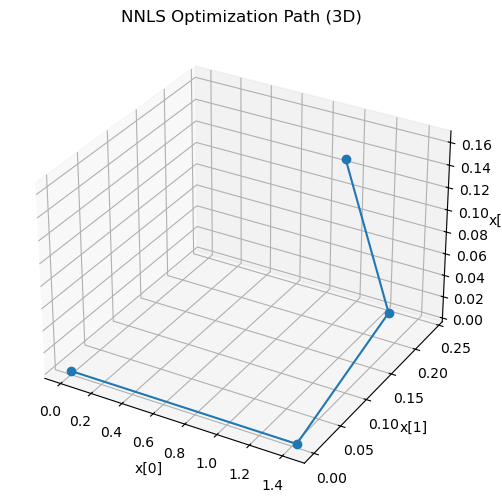

3D NNLS solution: [1.16666667 0.16666667 0.16666667]
Step 0: [0. 0. 0.]
Step 1: [1.4286 0.     0.    ]
Step 2: [1.24 0.24 0.  ]
Step 3: [1.1667 0.1667 0.1667]


In [22]:
# --- 3D Example ---
print("Running NNLS on a 3D example...")
# For a 3D NNLS problem, let A be 3x3 and b be 3x1.
X3D = np.array([[2, 1, 3],
              [1, 3, 2],
              [3, 2, 1]], dtype=float)

Y3D = np.array([3, 2, 4], dtype=float)

sol3D, path3D = nnls_path(X3D, Y3D)
plot_path(path3D, dimension=3)
print("3D NNLS solution:", sol3D)
for i, beta in enumerate(path3D):
    print(f"Step {i}: {np.round(beta, decimals=4)}")

In [23]:
# --- 4x4 Example ---
print("\nRunning NNLS on a 4x4 example...")
X4D = np.array([[2, 1, 3, 4],
                [1, 3, 2, 1],
                [4, 2, 5, 3],
                [2, 2, 2, 2]], dtype=float)
Y4D = np.array([3, 2, 4, 1], dtype=float)

sol4D, path4D = nnls_path(X4D, Y4D)
print("4D NNLS solution:", sol4D)
print("Optimization path steps:")
for i, beta in enumerate(path4D):
    print(f"Step {i}: {np.round(beta, decimals=4)}")


Running NNLS on a 4x4 example...
4D NNLS solution: [0.         0.         0.73684211 0.12280702]
Optimization path steps:
Step 0: [0. 0. 0. 0.]
Step 1: [0.     0.     0.8333 0.    ]
Step 2: [0.     0.     0.7368 0.1228]
